# Unity 3D 길 찾기 프로토타입 프로젝트 설명서

### 1. 프로토타입 제목 : 3D 그리드 기반 길 찾기 및 시각화 시스템

### 2. 프로토타입 설명 :
- **What** > 이 프로토타입은 Unity 3D 환경에서 그리드(Grid) 기반의 3차원 길 찾기 알고리즘을 구현하고 시각화하는 시스템입니다. 플레이어가 맵상의 특정 지점을 클릭하면, 해당 지점까지 최단 또는 최적의 경로를 계산하여 이동하며, 그 과정을 시각적으로 보여줍니다. 3가지 주요 길 찾기 알고리즘(BFS, Dijkstra, A*)을 선택하여 비교하고 테스트할 수 있습니다.

- **Who** > 가천대학교 재학생 및 신입생 그리고 외부 방문객들을 위해 만들었습니다.

- **When** > 모바일 환경 (+AR) 혹은 PC 환경에서 필요할 때 언제든지 사용할 수 있습니다.

- **Why** > 가천대학교 캠퍼스는 넓고 복잡하기 때문에, 건물 위치나 동선을 쉽게 이해할 수 있는 가상 안내 서비스가 필요하다고 생각했습니다. 또한 이 서비스는 이동에 어려움을 겪는 분들 (휠체어 사용자, 노약자, 임산부)의 불편함을 해소할 수 있습니다. 일반적인 이동 경로는 계단이나 경사로가 포함될 수 있어 안전하지 않으므로 엘리베이터와 경사로 중심의 접근 가능한 경로가 필요하다고 생각했습니다.

### 3. Input 데이터 :
데이터 모양 : 그리드 (Grid) 3차원 배열입니다. 이는 Node[,,] 형태로 표현됩니다.
각  Node 객체는 다음과 같은 속성을 가집니다.
- canWalk (bool): 해당 노드가 이동 가능한지(true) 또는 장애물(false)인지 나타냅니다.
- worldPosition (Vector3): 해당 노드의 3D 공간 상의 실제 월드 좌표입니다.
- gridX, gridY, gridZ (int): 3차원 그리드 배열 내에서의 인덱스(좌표)입니다.
- gCost (float): 시작 노드로부터 해당 노드까지의 실제 이동 비용입니다. (Dijkstra, A*에서 사용)
- hCost (float): 해당 노드로부터 목표 노드까지의 예상 이동 비용(휴리스틱)입니다. (A*에서 사용)
-fCost (float): gCost + hCost (총 예상 비용)입니다. (A*에서 사용)

출처 : 모든 Input 데이터는 제가 설정한 World Size, Node Radius, Obstacle Layer 등의 Parameter를 통해 생성됩니다. (외부 데이터가 아닌 런타임 시점에 Unity 엔진 내에서 생성 및 구성됩니다.)

### 4. 사용한 자료구조

- 3차원 배열 (Node[,,] grid)
  - 프로토타입에서 사용된 부분: PathGrid.cs 스크립트에서 전체 3D 공간을 이산적인 노드들로 표현하기 위해 사용했습니다. grid[x, y, z] 형태로 특정 좌표의 노드에 직접 접근할 수 있습니다.
  - 선택 이유: 3차원 공간을 균일한 격자 형태로 모델링하기에 가장 직관적이고 효율적인 자료구조입니다.

- 우선순위 큐 (PriorityQueue<T>)
  - 프로토타입에서 사용된 부분: PathfindingManager.cs의 다익스트라(Dijkstra) 및 A* 알고리즘에서 openSet으로 사용됩니다. 다음에 탐색할 노드 중 비용이 가장 낮은 노드를 효율적으로 선택하기 위해 사용됩니다.
  - 선택 이유: 다익스트라와 A* 알고리즘은 현재까지 발견된 경로 중 가장 비용이 낮은 노드를 우선적으로 탐색해야 합니다. 우선순위 큐는 이러한 요구사항을 충족시키기 위해 삽입(enqueue) 및 최솟값 추출(dequeue) 연산을 효율적으로(일반적으로 O(log N) 복잡도) 수행할 수 있도록 설계된 자료구조입니다. Contains 및 UpdatePriority 기능은 A* 알고리즘의 최적화된 구현을 위해 추가되었습니다.

- 해시셋 (HashSet<Node> closedSet)
  - 프로토타입에서 사용된 부분: PathfindingManager.cs의 모든 길 찾기 알고리즘(BFS, Dijkstra, A*)에서 이미 방문하여 탐색을 완료한 노드들을 저장하는 데 사용됩니다.
  - 선택 이유: 이미 방문한 노드를 다시 탐색하는 것을 방지하여 알고리즘의 효율성을 높이고 무한 루프를 막습니다. HashSet은 요소의 추가, 삭제 및 존재 여부 확인(Contains) 연산을 평균적으로 O(1)의 시간 복잡도로 매우 빠르게 수행할 수 있어, 많은 수의 노드를 다룰 때 성능상 이점을 제공합니다.

### 5. 사용한 알고리즘

- 너비 우선 탐색 (BFS: Breadth-First Search)
  - 알고리즘명: Breadth-First Search (BFS)
  - 프로토타입에서 사용된 부분: PathfindingManager.cs의 FindPathBFS 함수에서 구현됩니다. 최단 거리(간선 수 기준) 경로를 찾기 위해 큐(Queue)를 사용하여 시작 노드에서부터 인접 노드를 층별로 탐색해 나갑니다.
  - 선택 이유: 가중치가 없는 그래프(또는 모든 간선 비용이 동일한 경우)에서 최단 경로를 찾는 가장 간단하고 효율적인 알고리즘이기에 선택했습니다. 구현이 비교적 쉬워서 간단하게 확인해보고 싶을 때 유용하다고 생각했습니다.

- 다익스트라 알고리즘 (Dijkstra's Algorithm)
  - 알고리즘명: Dijkstra's Algorithm
  - 프로토타입에서 사용된 부분: PathfindingManager.cs의 FindPathDijkstra 함수에서 구현됩니다. 우선순위 큐(PriorityQueue)를 사용하여 시작 노드로부터 모든 다른 노드까지의 최단 경로를 찾습니다. 각 노드 간의 거리를 비용으로 사용하여 최단 "거리" 경로를 보장합니다.
  - 선택 이유: 간선 가중치가 양수인 그래프에서 단일 시작점에서 모든 다른 노드까지의 최단 경로를 찾는 데 사용되는 대표적인 알고리즘입니다. A* 알고리즘과 비교하여 휴리스틱 없이 작동하는 유료(가중치) 그래프 탐색의 기본을 보여주고자 선택했습니다.

- A* 알고리즘 (A* Search Algorithm)
  - 알고리즘명: A* Search Algorithm
  - 프로토타입에서 사용된 부분: PathfindingManager.cs의 FindPathAStar 함수에서 구현됩니다. 우선순위 큐(PriorityQueue)를 사용하며, 각 노드에 대해 시작점으로부터의 실제 비용(gCost)과 목표점까지의 예상 비용(hCost, 휴리스틱)을 합산한 총 비용(fCost = gCost + hCost)을 기준으로 탐색합니다.
  - 선택 이유: 게임에서 가장 널리 사용되고 효율적인 길 찾기 알고리즘입니다. 휴리스틱을 사용하여 목표 지점 방향으로 탐색을 유도함으로써 다익스트라보다 탐색 공간을 줄여 더 빠르게 최단 경로를 찾을 수 있습니다. 실시간 게임 환경에서 최적의 성능을 제공하는 알고리즘으로 중요성이 높아 선택했습니다.

### 6. 설계/구현 방법

- 사용한 툴 : Blender, Substance 3D Painter, Unity (URP)

- Architecture :     
이 프로토타입은 MVC (Moel-View-Controller) 설계 패러다임의 요소를 차용하여 구성되었습니다.
  - Model     
    - Node.cs : 개별 그리드 셀의 상태를 정의하는 데이터 모델
    - PathGrid.cs : 전체 3D 그리드를 관리하고 노드 생성 등의 핵심 로직 담당
  - Controller
    - PathfindingManager.cs : BFS, Dijkstra, A*와 같은 실제 길 찾기 알고리즘을 구현하고 실행하는 핵심 제어 로직입니다
    - PlayerController.cs : 사용자의 입력을 받아 (마우스 클릭) 길 찾기 요청을 PathfindingManager에 전달하고, 반환된 경로를 따라 플레이어를 이동시키는 역할을 합니다.
    - CameraController.cs: 플레이어의 움직임에 따라 카메라를 부드럽게 추적하거나, 특정 시점으로 전환하는 로직을 담당합니다.
  - View
    - PathGrid.cs의 OnDrawGizmos(): 에디터(Scene 뷰)에서 그리드 노드와 장애물, 그리고 계산된 경로를 시각적으로 보여주는 디버깅 기능입니다.
    - PlayerController.cs의 VisualizePath(): 게임 오브젝트(작은 큐브 프리팹)를 사용하여 게임 뷰에서 플레이어의 이동 경로를 시각적으로 표시합니다.

- 동작 방식 :    
  - 초기화 : PathGrid 컴포넌트가 Awake에서 싱글톤 인스턴스를 설정하고, Start에서 worldSize, nodeRadius, obstacleLayer 등의 설정 값을 기반으로 3차원 노드 그리드를 생성합니다.

  - 사용자 입력 : PlayerController의 Update 함수는 마우스 왼쪽 버튼 클릭을 감지합니다. 클릭 지점에 Raycast를 쏘면 SelectablePathCube 컴포넌트가 있는 오브젝트를 식별해서 목표 월드 좌표를 추출합니다.

  - 경로 요청 및 계산 : PlayerController는 PathfindingManager.Instance.FindPath(algorithm, startPos, targetPos) 함수를 호출하여 길 찾기 요청을 합니다.

  - 플레이어 이동 및 경로 시각화 : MoveAlongPath()는 경로의 각 노드를 순서대로 목표 지점으로 삼아 Vector3.MoveTowards를 사용하여 플레이어 큐브를 부드럽게 이동시킵니다.

- 핵심 코드 :

(해당 코드는 Colab 환경에서도 실행할 수 있게끔 새로 만들어봤습니다. 이 역시 동일한 알고리즘과 자료구조를 사용합니다. 단지 사용자 입력 방식과 데이터 표현의 차원, 그리고 시각화 방법에서 환경적 제약에 따른 차이만이 발생했습니다.


--- 2D 길 찾기 시뮬레이터 ---
그리드 크기: 15x15
알고리즘을 선택하세요:
1. BFS (너비 우선 탐색)
2. Dijkstra's Algorithm (다익스트라 알고리즘)
3. A* Algorithm (A* 알고리즘)
4. 종료
선택 (1-4): 1

시작 좌표를 입력하세요 (x y, 예: 0 0): 
0 0
목표 좌표를 입력하세요 (x y, 예: 14 14): 
14 14

BFS 알고리즘을 사용하여 (0, 0)에서 (14, 14)까지 경로를 계산 중...
경로를 찾았습니다! 길이: 20 노드.
경로: ['(0,0)', '(0,1)', '(0,2)', '(0,3)', '(0,4)', '(0,5)', '(1,6)', '(2,7)', '(3,8)', '(4,9)', '(5,10)', '(6,9)', '(7,8)', '(8,8)', '(9,9)', '(10,10)', '(11,11)', '(12,12)', '(13,13)', '(14,14)']


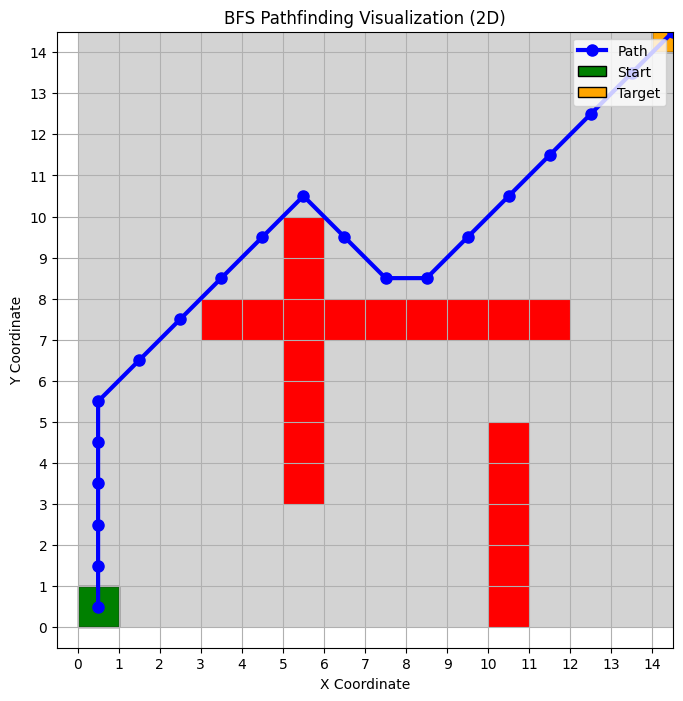


--- 2D 길 찾기 시뮬레이터 ---
그리드 크기: 15x15
알고리즘을 선택하세요:
1. BFS (너비 우선 탐색)
2. Dijkstra's Algorithm (다익스트라 알고리즘)
3. A* Algorithm (A* 알고리즘)
4. 종료
선택 (1-4): 4
시뮬레이터를 종료합니다. 안녕히 계세요!


In [6]:
import collections # 큐(deque) 사용을 위함
import heapq       # 우선순위 큐(min-heap) 사용을 위함
import math        # 유클리드 거리 계산을 위함 (sqrt)
import matplotlib.pyplot as plt # 2D 시각화를 위함
import numpy as np # 시각화 플롯 설정 (xticks, yticks 등)

# --- 1. Node 클래스 정의 (2D 버전) ---
# 그리드 내의 각 지점(셀)을 나타내는 클래스
class Node:
    def __init__(self, x, y, can_walk=True):
        self.x = x # 노드의 X 좌표 (그리드 인덱스)
        self.y = y # 노드의 Y 좌표 (그리드 인덱스)
        self.can_walk = can_walk # 해당 노드가 이동 가능한지 (True: 가능, False: 장애물)

        # 길 찾기 알고리즘 계산 비용
        self.g_cost = float('inf') # 시작 노드부터 현재 노드까지의 실제 이동 비용
        self.h_cost = 0.0          # 현재 노드부터 목표 노드까지의 예상 이동 비용 (휴리스틱)
        self.parent = None         # 경로 재구성을 위한 부모 노드 (이전 노드를 추적)

        self.neighbors = [] # 해당 노드의 인접 노드 리스트 (PathGrid에서 채워짐)

    @property
    def f_cost(self):
        # A* 알고리즘의 총 예상 비용: f = g + h
        return self.g_cost + self.h_cost

    # 두 노드가 같은지 비교하기 위한 메서드 (set, dictionary 사용 시 필수)
    def __eq__(self, other):
        return isinstance(other, Node) and self.x == other.x and self.y == other.y

    # 노드 객체를 해시 가능하게 만들기 위한 메서드 (set, dictionary 키로 사용 시 필수)
    def __hash__(self):
        return hash((self.x, self.y))

    # heapq (우선순위 큐)에서 노드 간의 우선순위를 비교하기 위한 메서드
    def __lt__(self, other):
        # f_cost가 같을 경우, h_cost가 더 낮은 노드(목표에 더 가까울 것으로 예상되는 노드)를 선호하여 탐색 효율을 높임 (타이 브레이킹)
        if self.f_cost == other.f_cost:
            return self.h_cost < other.h_cost
        return self.f_cost < other.f_cost

    # 노드 객체를 문자열로 표현할 때 사용
    def __repr__(self):
        return f"Node({self.x},{self.y},walk={self.can_walk})"

# --- 2. PathGrid 클래스 정의 (2D 버전) ---
# 전체 2D 그리드를 생성하고 관리하는 클래스
class PathGrid:
    def __init__(self, size_x, size_y, obstacle_coords=None):
        self.grid_size_x = size_x # 그리드의 가로 크기
        self.grid_size_y = size_y # 그리드의 세로 크기
        # 그리드 노드를 저장하는 딕셔너리: (x, y) 좌표 튜플을 키로 사용, Node 객체를 값으로 저장
        # 이는 Unity의 Node[,] (2D 배열)와 유사하게 그리드 데이터를 표현함.
        self.grid = {}

        self._create_grid(obstacle_coords if obstacle_coords else []) # 그리드 노드 생성 및 장애물 설정
        self._connect_neighbors() # 각 노드의 이웃 노드 연결

    # 그리드 노드를 생성하고 장애물을 표시
    def _create_grid(self, obstacle_coords):
        for x in range(self.grid_size_x):
            for y in range(self.grid_size_y):
                is_obstacle = (x, y) in obstacle_coords
                self.grid[(x, y)] = Node(x, y, not is_obstacle)

    # 각 노드에 인접한 노드들을 찾아 연결
    def _connect_neighbors(self):
        for x in range(self.grid_size_x):
            for y in range(self.grid_size_y):
                node = self.grid[(x, y)]
                node.neighbors = self._get_neighbors(node)

    # 특정 노드의 유효한 이웃 노드들을 반환
    def _get_neighbors(self, node):
        neighbors = []
        # 8방향 이동 (상하좌우 및 대각선)을 고려
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0: # 자기 자신은 건너뛰기
                    continue

                nx, ny = node.x + dx, node.y + dy

                # 이웃 노드가 그리드 범위 내에 있는지 확인
                if (0 <= nx < self.grid_size_x and
                    0 <= ny < self.grid_size_y):

                    neighbor_node = self.grid[(nx, ny)]
                    if neighbor_node.can_walk: # 이웃 노드가 이동 가능한지 확인
                        neighbors.append(neighbor_node)
        return neighbors

    # 그리드 좌표를 통해 특정 노드를 가져옴
    def get_node(self, x, y):
        if (0 <= x < self.grid_size_x and
            0 <= y < self.grid_size_y):
            return self.grid.get((x, y)) # 안전하게 노드를 가져옴
        return None

    # 모든 노드를 반환 (알고리즘 초기화 등에 사용)
    def get_all_nodes(self):
        return self.grid.values()

# --- 3. PathfindingManager 클래스 정의 (2D 버전) ---
# 길 찾기 알고리즘(BFS, Dijkstra, A*)을 관리하고 실행하는 클래스
# Unity의 PathfindingManager.cs와 동일한 역할을 수행
class PathfindingManager:
    def __init__(self, grid_instance):
        self.grid = grid_instance # PathGrid 인스턴스 참조

    # 두 노드 간의 거리를 계산하는 헬퍼 함수
    # 이 프로토타입에서는 유클리드 거리(대각선 이동 비용을 반영)를 사용
    # Unity의 Vector3.Distance와 유사한 역할을 함
    def _get_distance(self, nodeA, nodeB):
        # 유클리드 거리: 실제 공간에서 두 점 사이의 최단 거리
        # 그리드에서 대각선 이동 시 비용을 더 현실적으로 반영 (ex. (0,0) -> (1,1)은 sqrt(2) 비용)
        return math.sqrt((nodeA.x - nodeB.x)**2 + (nodeA.y - nodeB.y)**2)
        # 맨해튼 거리 (선택 사항, 대각선 이동 시 비용이 1로 통일되거나 대각선 이동을 허용하지 않을 때 사용):
        # return abs(nodeA.x - nodeB.x) + abs(nodeA.y - nodeB.y)

    # 목표 노드에서부터 부모 노드를 역추적하여 전체 경로를 재구성하는 함수
    def _reconstruct_path(self, start_node, target_node):
        path = []
        current = target_node
        while current and current != start_node: # 시작 노드에 도달할 때까지 역추적
            path.append(current)
            current = current.parent
        if current == start_node: # 시작 노드를 경로에 추가
            path.append(start_node)
        path.reverse() # 경로를 시작 -> 목표 순서로 뒤집음
        return path

    # BFS (너비 우선 탐색) 알고리즘
    # 가중치가 없는 그래프(모든 간선 비용이 동일한 경우)에서 최단 경로를 찾는 데 최적
    # 휴리스틱 없이 시작점에서부터 층별로 탐색해 나감
    def find_path_bfs(self, start_coords, target_coords):
        start_node = self.grid.get_node(*start_coords)
        target_node = self.grid.get_node(*target_coords)

        if not start_node or not target_node or not start_node.can_walk or not target_node.can_walk:
            print("BFS: 시작 또는 목표 노드가 유효하지 않거나 이동 불가능합니다.")
            return None

        # 탐색할 노드들을 저장하는 큐 (collections.deque는 양방향 큐로 효율적)
        queue = collections.deque([start_node])
        # 이미 방문한 노드들을 저장하는 집합 (HashSet과 유사, 빠른 검색 가능)
        visited = {start_node}

        # 검색 전 모든 노드의 부모 포인터 초기화
        for node in self.grid.get_all_nodes():
            node.parent = None

        while queue:
            current_node = queue.popleft() # 큐의 가장 앞에 있는 노드 추출 (FIFO)

            if current_node == target_node: # 목표 노드에 도달했으면 경로 재구성
                return self._reconstruct_path(start_node, target_node)

            for neighbor in current_node.neighbors: # 현재 노드의 이웃 노드들을 탐색
                if neighbor not in visited and neighbor.can_walk: # 방문하지 않았고 이동 가능하면
                    visited.add(neighbor) # 방문 목록에 추가
                    neighbor.parent = current_node # 부모 노드 설정
                    queue.append(neighbor) # 큐에 추가하여 나중에 탐색
        return None # 경로를 찾지 못함

    # Dijkstra's Algorithm (다익스트라 알고리즘)
    # 간선 가중치(이동 비용)가 양수인 그래프에서 시작 노드로부터 모든 다른 노드까지의 최단 경로를 찾음
    # BFS와 달리 노드 간 이동 비용이 다를 수 있을 때 사용 (예: 대각선 이동 비용이 더 클 때)
    def find_path_dijkstra(self, start_coords, target_coords):
        start_node = self.grid.get_node(*start_coords)
        target_node = self.grid.get_node(*target_coords)

        if not start_node or not target_node or not start_node.can_walk or not target_node.can_walk:
            print("Dijkstra: 시작 또는 목표 노드가 유효하지 않거나 이동 불가능합니다.")
            return None

        # 검색 전 모든 노드의 비용과 부모 초기화
        for node in self.grid.get_all_nodes():
            node.g_cost = float('inf')
            node.parent = None

        start_node.g_cost = 0 # 시작 노드의 비용은 0
        # 탐색할 노드들을 저장하는 우선순위 큐 (heapq는 튜플의 첫 번째 요소를 기준으로 정렬)
        # 항상 비용이 가장 낮은 노드를 먼저 처리하기 위함
        priority_queue = [(0, start_node)] # (비용, 노드 객체) 튜플 저장
        # 이미 최단 경로가 확정되어 처리 완료된 노드들을 저장하는 집합
        visited = set()

        while priority_queue:
            current_cost, current_node = heapq.heappop(priority_queue) # 가장 낮은 비용의 노드 추출

            if current_node in visited: # 이미 처리된 노드면 건너뛰기
                continue
            visited.add(current_node) # 현재 노드를 방문 완료로 표시

            if current_node == target_node: # 목표 노드에 도달했으면 경로 재구성
                return self._reconstruct_path(start_node, target_node)

            for neighbor in current_node.neighbors: # 이웃 노드 탐색
                if neighbor.can_walk: # 이웃 노드가 이동 가능하면
                    # 현재 노드를 거쳐 이웃 노드로 가는 새로운 비용 계산
                    edge_cost = self._get_distance(current_node, neighbor)
                    new_g_cost = current_node.g_cost + edge_cost

                    if new_g_cost < neighbor.g_cost: # 새로운 경로가 더 짧으면
                        neighbor.g_cost = new_g_cost # 비용 갱신
                        neighbor.parent = current_node # 부모 설정
                        heapq.heappush(priority_queue, (neighbor.g_cost, neighbor)) # 우선순위 큐에 추가/갱신
        return None # 경로를 찾지 못함

    # A* Algorithm (A* 알고리즘)
    # 다익스트라 알고리즘에 휴리스틱(h_cost)을 추가하여 목표 지점 방향으로 탐색을 유도
    # 게임 길 찾기에 가장 널리 사용되며, 최단 경로를 찾으면서도 효율적
    def find_path_a_star(self, start_coords, target_coords):
        start_node = self.grid.get_node(*start_coords)
        target_node = self.grid.get_node(*target_coords)

        if not start_node or not target_node or not start_node.can_walk or not target_node.can_walk:
            print("A*: 시작 또는 목표 노드가 유효하지 않거나 이동 불가능합니다.")
            return None

        # 검색 전 모든 노드의 비용과 부모 초기화
        for node in self.grid.get_all_nodes():
            node.g_cost = float('inf')
            node.h_cost = 0.0
            node.parent = None

        start_node.g_cost = 0 # 시작 노드의 g_cost는 0
        # 시작 노드의 h_cost (휴리스틱) 계산
        start_node.h_cost = self._get_distance(start_node, target_node)

        # 탐색할 노드들을 저장하는 우선순위 큐 (f_cost 기준으로 정렬)
        open_set = [(start_node.f_cost, start_node)]

        # open_set에 있는 노드들을 빠르게 확인하기 위한 집합 (heapq는 직접 검색 기능 없음)
        open_set_nodes = {start_node}

        # 이미 최단 경로가 확정되어 처리 완료된 노드들을 저장하는 집합
        closed_set = set()

        while open_set:
            current_f_cost, current_node = heapq.heappop(open_set) # f_cost가 가장 낮은 노드 추출

            if current_node in closed_set: # 이미 처리된 노드면 건너뛰기
                continue

            closed_set.add(current_node) # 현재 노드를 closed_set에 추가
            open_set_nodes.remove(current_node) # open_set_nodes에서도 제거

            if current_node == target_node: # 목표 노드에 도달했으면 경로 재구성
                return self._reconstruct_path(start_node, target_node)

            for neighbor in current_node.neighbors: # 이웃 노드 탐색
                if neighbor in closed_set or not neighbor.can_walk: # 이미 처리되었거나 이동 불가능하면 건너뛰기
                    continue

                # 현재 노드를 거쳐 이웃 노드로 가는 새로운 g_cost 계산
                edge_cost = self._get_distance(current_node, neighbor)
                new_g_cost = current_node.g_cost + edge_cost

                if new_g_cost < neighbor.g_cost: # 새로운 경로가 더 짧으면 (최적 경로 발견)
                    neighbor.g_cost = new_g_cost # g_cost 갱신
                    neighbor.h_cost = self._get_distance(neighbor, target_node) # h_cost (휴리스틱) 갱신
                    neighbor.parent = current_node # 부모 노드 설정

                    if neighbor not in open_set_nodes: # open_set에 없으면 추가
                        heapq.heappush(open_set, (neighbor.f_cost, neighbor))
                        open_set_nodes.add(neighbor)
                    # Note: heapq는 요소의 우선순위를 직접 업데이트하는 기능이 없어,
                    # 더 낮은 f_cost를 가진 새 항목을 다시 push하여 업데이트 효과를 냄.
                    # 이미 있는 더 높은 f_cost 항목은 나중에 pop될 때 closed_set에서 걸러짐.
        return None # 경로를 찾지 못함

# --- 4. 시각화 함수 (2D 버전) ---
# matplotlib을 사용하여 2D 그리드와 경로를 시각적으로 표현
def plot_2d_grid_path(grid_instance, path, start_coords, target_coords, algorithm_name="Pathfinding"):
    plt.figure(figsize=(8, 8)) # 플롯의 크기 설정
    ax = plt.gca() # 현재 축(Axes) 객체를 가져옴

    # 모든 그리드 노드를 사각형으로 표시
    for x in range(grid_instance.grid_size_x):
        for y in range(grid_instance.grid_size_y):
            node = grid_instance.get_node(x, y)
            color = 'lightgray' if node.can_walk else 'red' # 이동 가능하면 회색, 장애물은 빨간색
            # Rectangle 패치를 추가하여 그리드 셀을 그림
            ax.add_patch(plt.Rectangle((x, y), 1, 1, facecolor=color, edgecolor='black', linewidth=0.5))

    # 계산된 경로를 파란색 선과 원형 마커로 표시
    if path:
        path_x = [node.x + 0.5 for node in path] # 셀의 중앙을 통과하도록 x좌표 보정
        path_y = [node.y + 0.5 for node in path] # 셀의 중앙을 통과하도록 y좌표 보정
        plt.plot(path_x, path_y, color='blue', linewidth=3, marker='o', markersize=8, label='Path')

    # 시작 노드를 녹색 사각형으로 표시
    if start_coords:
        ax.add_patch(plt.Rectangle((start_coords[0], start_coords[1]), 1, 1, facecolor='green', edgecolor='black', linewidth=1, label='Start'))
    # 목표 노드를 주황색 사각형으로 표시
    if target_coords:
        ax.add_patch(plt.Rectangle((target_coords[0], target_coords[1]), 1, 1, facecolor='orange', edgecolor='black', linewidth=1, label='Target'))

    # 플롯의 X, Y 축 범위 및 눈금 설정
    ax.set_xlim(-0.5, grid_instance.grid_size_x - 0.5)
    ax.set_ylim(-0.5, grid_instance.grid_size_y - 0.5)
    ax.set_xticks(np.arange(0, grid_instance.grid_size_x, 1))
    ax.set_yticks(np.arange(0, grid_instance.grid_size_y, 1))
    ax.set_aspect('equal', adjustable='box') # X, Y 축 비율을 같게 하여 정사각형 그리드처럼 보이게 함
    ax.set_title(f"{algorithm_name} Pathfinding Visualization (2D)") # 플롯 제목
    ax.set_xlabel('X Coordinate') # X축 레이블
    ax.set_ylabel('Y Coordinate') # Y축 레이블
    plt.grid(True) # 그리드 선 표시
    plt.legend(loc='upper right') # 범례 표시
    plt.show() # 플롯 보여주기


# --- 메인 실행 로직 ---
# 프로그램이 직접 실행될 때 실행되는 부분
if __name__ == "__main__":
    # 그리드 크기 정의 (예: 15x15)
    GRID_SIZE_X = 15
    GRID_SIZE_Y = 15

    # 장애물 좌표 설정 (예시 맵)
    # set을 사용하는 이유는 장애물 좌표의 빠른 검색 및 중복 방지를 위함
    obstacle_coordinates = set([
        (5, y) for y in range(3, 10) # X=5에 세로 벽
    ] + [
        (x, 7) for x in range(3, 12) if x != 5 # Y=7에 가로 벽 (X=5에서 뚫려있음)
    ] + [
        (10, y) for y in range(0, 5) # X=10에 세로 벽
    ])

    # PathGrid 인스턴스 생성 (그리드와 장애물 초기화)
    grid_instance = PathGrid(GRID_SIZE_X, GRID_SIZE_Y, obstacle_coordinates)

    # PathfindingManager 인스턴스 생성 (길 찾기 알고리즘 실행 담당)
    pf_manager = PathfindingManager(grid_instance)

    # 시뮬레이션 루프
    while True:
        print("\n--- 2D 길 찾기 시뮬레이터 ---")
        print(f"그리드 크기: {GRID_SIZE_X}x{GRID_SIZE_Y}")
        print("알고리즘을 선택하세요:")
        print("1. BFS (너비 우선 탐색)")
        print("2. Dijkstra's Algorithm (다익스트라 알고리즘)")
        print("3. A* Algorithm (A* 알고리즘)")
        print("4. 종료")

        choice = input("선택 (1-4): ")

        if choice == '4':
            print("시뮬레이터를 종료합니다. 안녕히 계세요!")
            break

        try:
            # 선택된 알고리즘에 따라 함수 매핑
            algo_map = {
                '1': ("BFS", pf_manager.find_path_bfs),
                '2': ("Dijkstra", pf_manager.find_path_dijkstra),
                '3': ("A*", pf_manager.find_path_a_star)
            }
            algo_name, find_path_func = algo_map[choice]

            # 시작 좌표 입력
            print("\n시작 좌표를 입력하세요 (x y, 예: 0 0): ")
            start_input = list(map(int, input().split()))
            if len(start_input) != 2: raise ValueError("시작 좌표 입력이 올바르지 않습니다 (숫자 2개 필요).")
            start_coords = tuple(start_input)

            # 목표 좌표 입력
            print("목표 좌표를 입력하세요 (x y, 예: 14 14): ")
            target_input = list(map(int, input().split()))
            if len(target_input) != 2: raise ValueError("목표 좌표 입력이 올바르지 않습니다 (숫자 2개 필요).")
            target_coords = tuple(target_input)

            print(f"\n{algo_name} 알고리즘을 사용하여 {start_coords}에서 {target_coords}까지 경로를 계산 중...")

            # 선택된 알고리즘 함수를 호출하여 경로 계산
            path = find_path_func(start_coords, target_coords)

            if path:
                print(f"경로를 찾았습니다! 길이: {len(path)} 노드.")
                print("경로:", [f"({n.x},{n.y})" for n in path])

                # 계산된 경로를 2D로 시각화
                plot_2d_grid_path(grid_instance, path, start_coords, target_coords, algo_name)
            else:
                print("경로를 찾을 수 없습니다.")
                # 경로를 찾지 못했어도 그리드와 시작/목표 지점은 표시
                plot_2d_grid_path(grid_instance, None, start_coords, target_coords, algo_name)

        except ValueError as e:
            print(f"잘못된 입력: {e}. 숫자만 공백으로 구분하여 입력해주세요.")
        except KeyError:
            print("잘못된 선택입니다. 1에서 4 사이의 숫자를 입력해주세요.")
        except Exception as e:
            print(f"예상치 못한 오류가 발생했습니다: {e}")

### 7. 최종 완성 결과

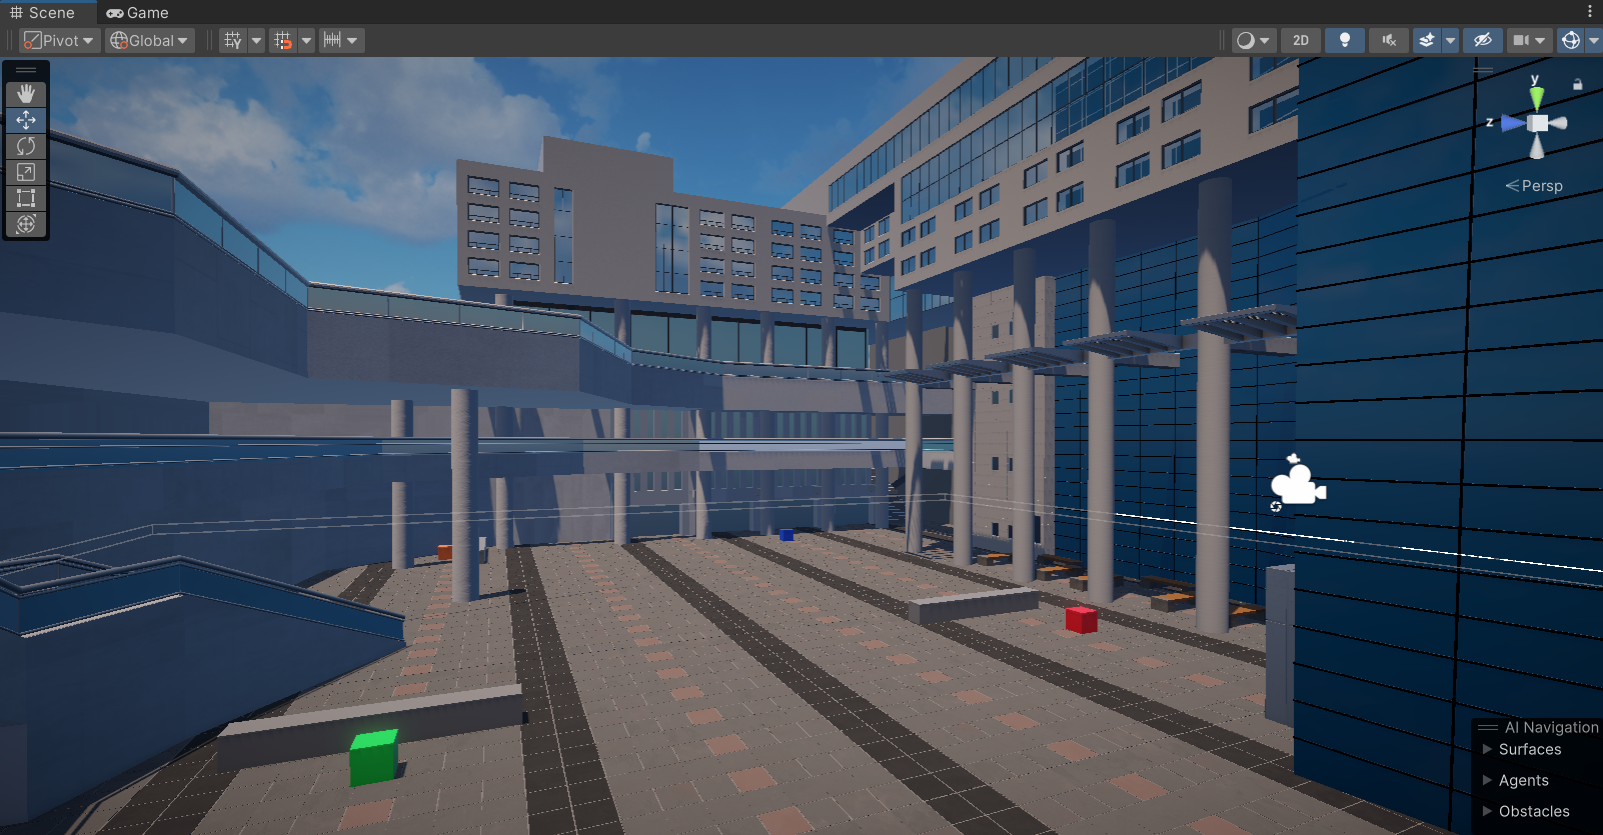

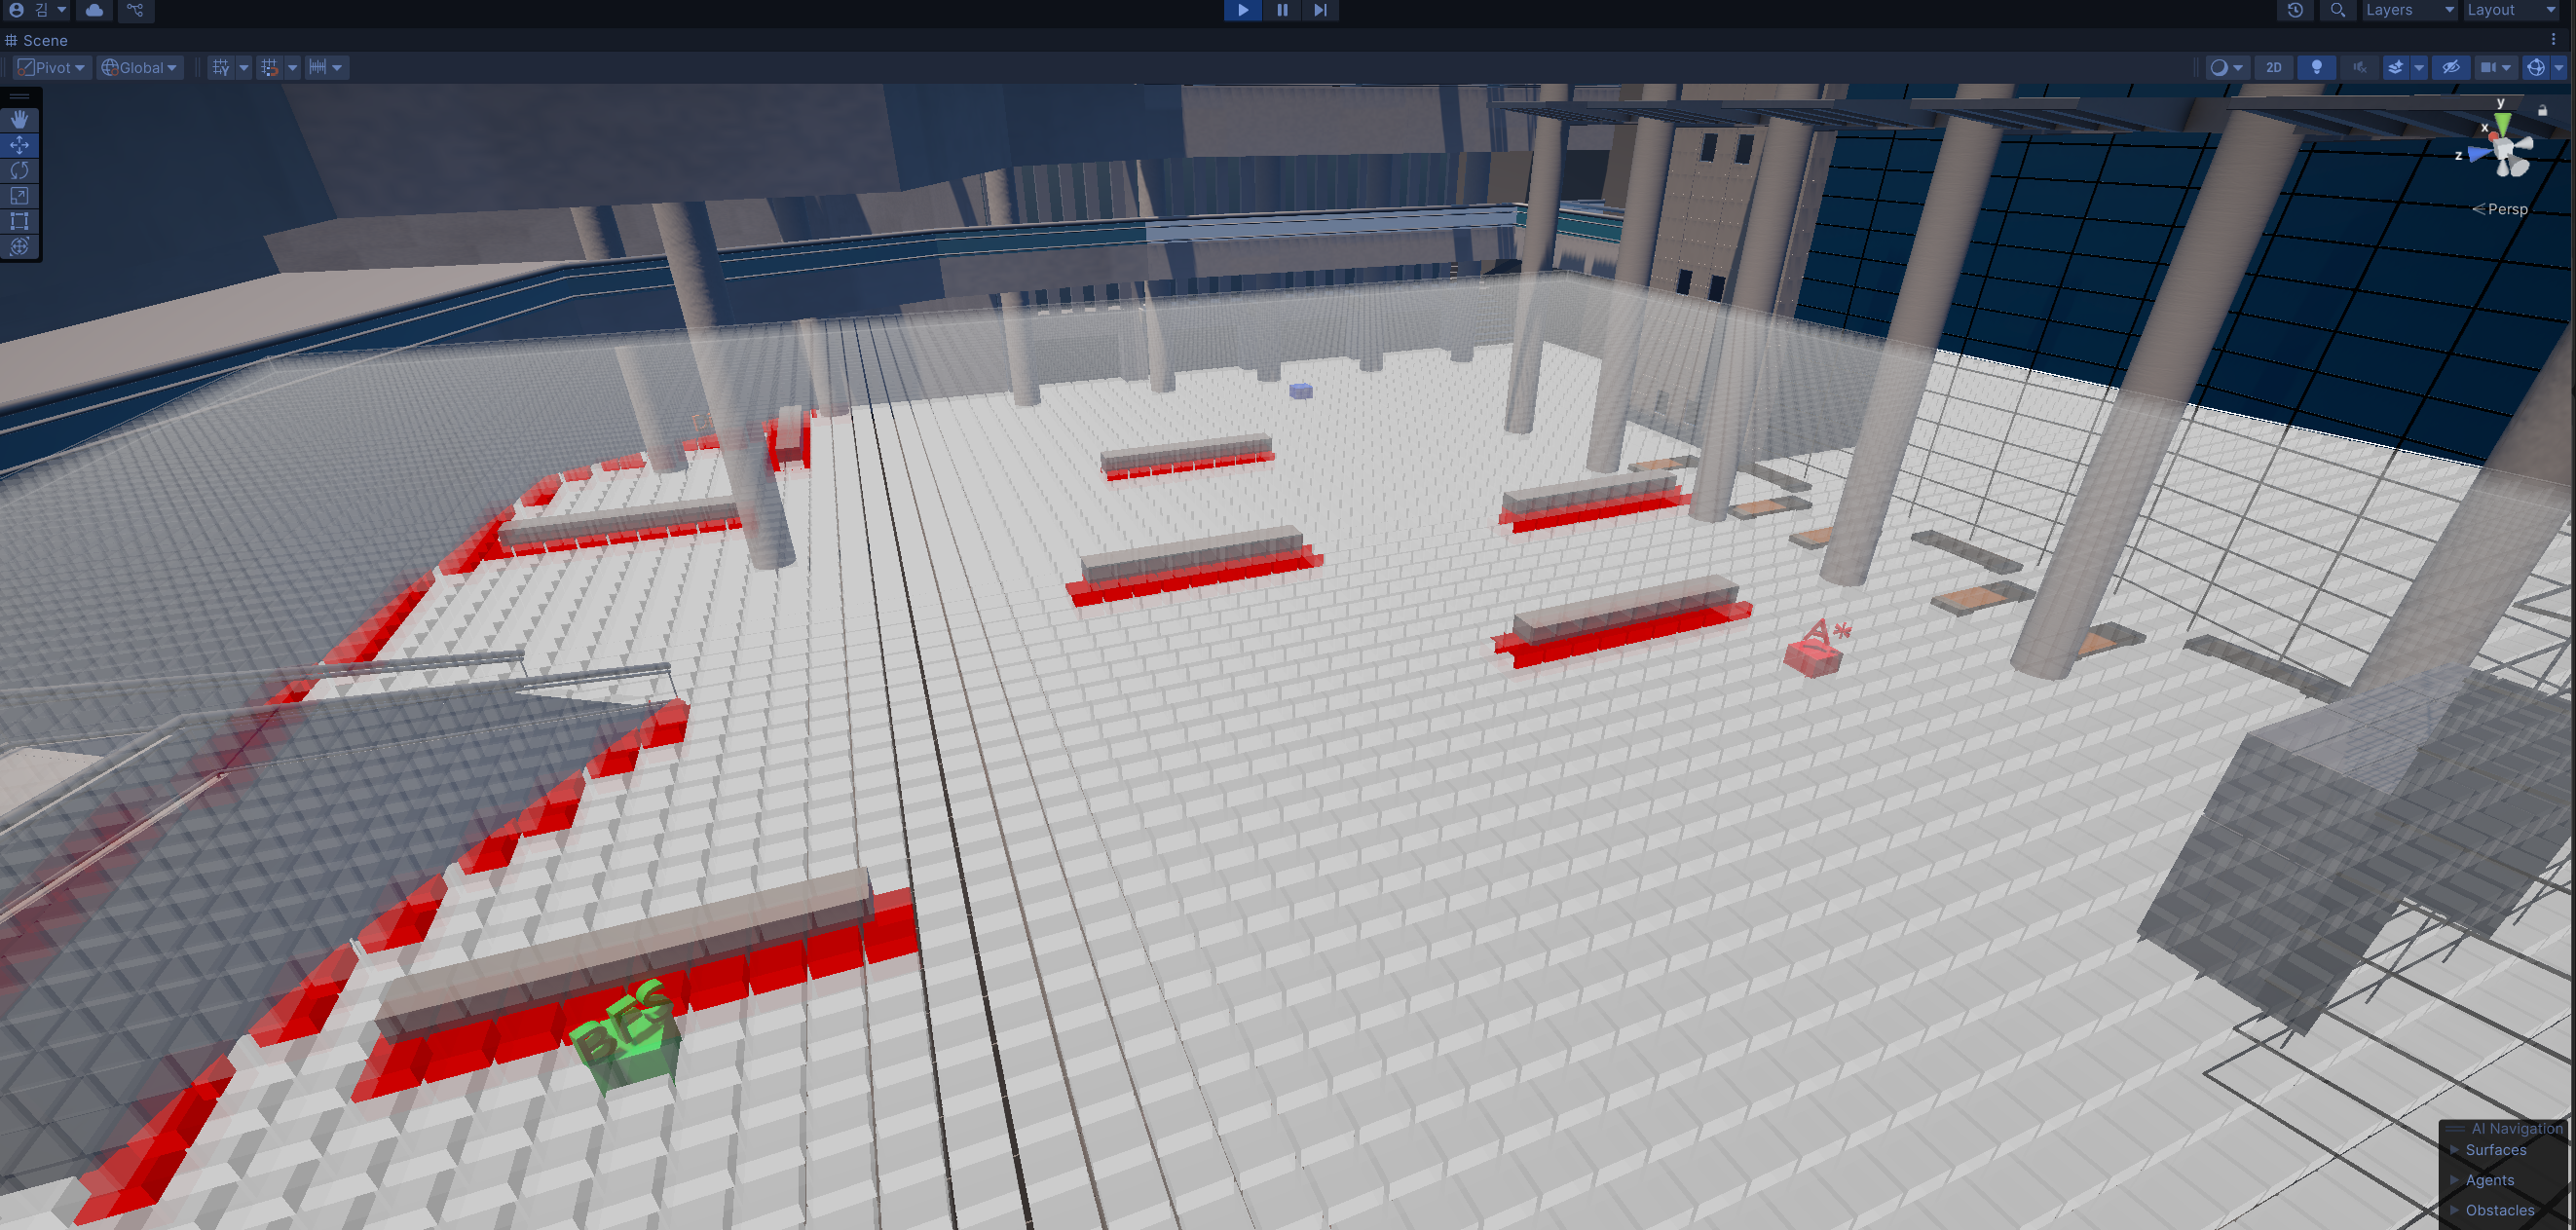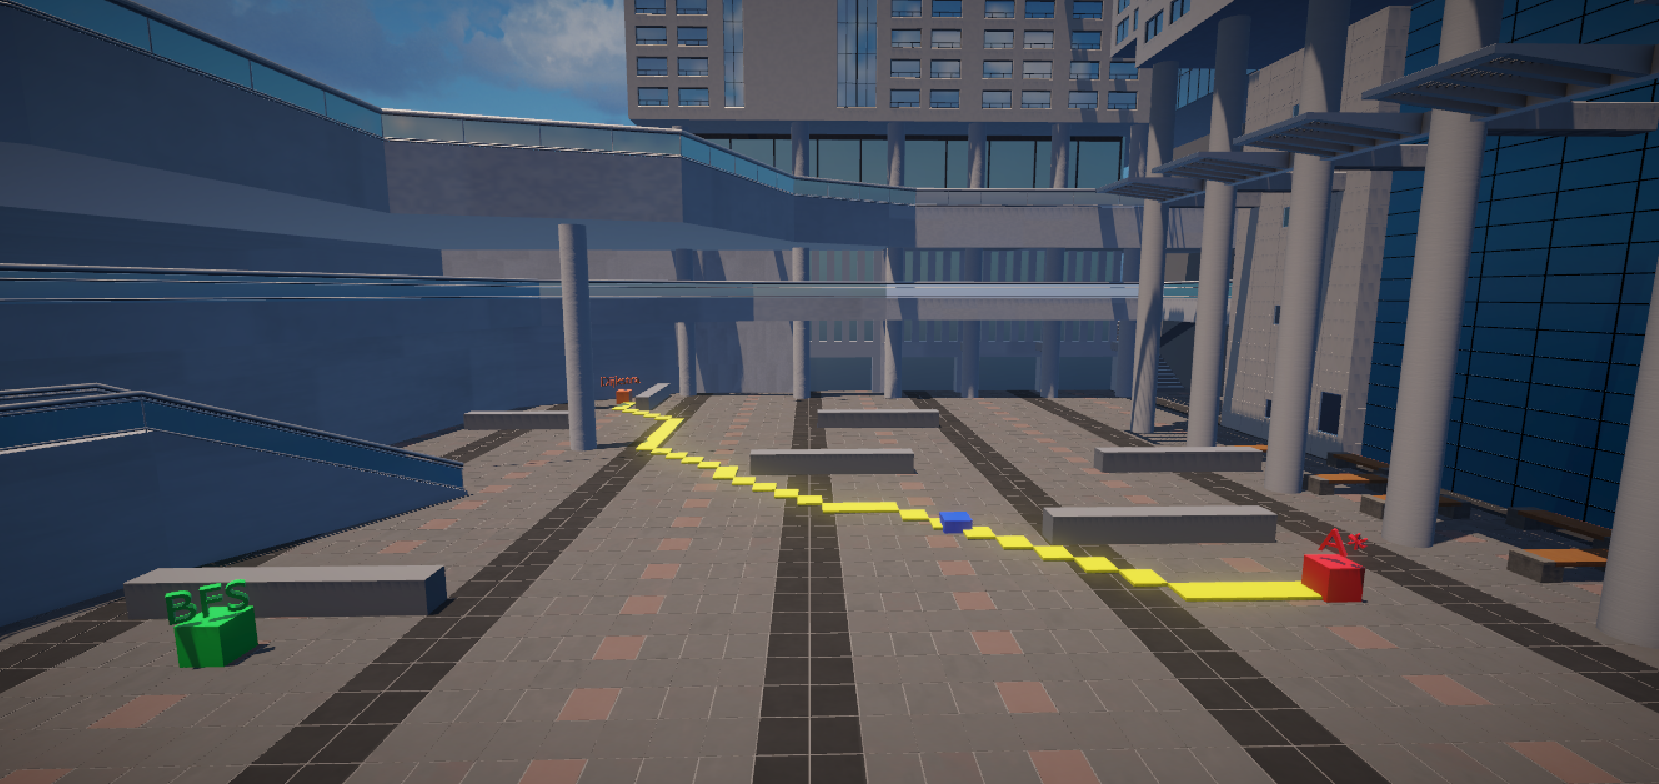

### 8. Lesson Learned : 작업과정 or 결과물에 대한 자신의 느낀 점이나 생각 등을 PMI(Plus-Minus-Interesting) 항목대로 기술하기

- 장점 :
  - 시각적 3D 경로 안내로 실사용자의 이해도를 크게 향상시킬 수 있습니다.
  - 장애인, 신입생 등에게 접근성이 좋습니다.
  - Unity 기반 프로토타입이기 때문에 다양한 확장이 가능합니다. (VR, AR)

- 단점 :
  - 구현 난이도가 너무 높습니다. (3D 환경 + 경로 알고리즘의 시각화 등)
  - 배포 시 최적화가 더 필요할 것 같습니다. (Vertex의 수 + 텍스쳐의 해상도 등)
  - 비용이 너무 많이 들어갑니다.

- 흥미로운 점 :    
  - 알고리즘의 시각화가 가능하기 때문에 많은 사용자들이 쉽게 이해할 수 있습니다.
  - 비전공자에게 교육용 자료로 쓰일 수도 있을 것 같습니다!!

프로그램 완성 코드

1. 실행 환경 기술하기 : Unity
2. 실행 시 필요한 라이브러리 기술하기 : X (우선 순위 큐도 구현했습니다)
3. 완성 코드에 자료구조, 알고리즘명 부분에 주석으로 표시하기

### PathfindingManager.cs
```csharp
using UnityEngine;
using System.Collections;
using System.Collections.Generic;

// --- 열거형(Enum) ---
// 어떤 알고리즘을 사용할지 선택할 수 있게 해주는 열거형
public enum PathfindingAlgorithm
{
    Dijkstra,  // 최단 경로 탐색 (가중치 O)
    AStar,     // 휴리스틱 기반 최단 경로 탐색 (가중치 O, 휴리스틱 O)
    BFS        // 너비 우선 탐색 (가중치 X, 최단거리만 보장)
}

public class PathfindingManager : MonoBehaviour
{
    public static PathfindingManager Instance { get; private set; }

    void Awake()
    {
        if (Instance == null) Instance = this;
        else Destroy(gameObject);
    }

    // ==========================
    // BFS (Breadth-First Search)
    // ==========================
    public List<Node> FindPathBFS(Vector3 startPos, Vector3 targetPos)
    {
        Node startNode = PathGrid.Instance.GetNodeFromWorldPoint(startPos);
        Node targetNode = PathGrid.Instance.GetNodeFromWorldPoint(targetPos);

        if (!startNode.canWalk || !targetNode.canWalk)
        {
            Debug.LogWarning("BFS: 시작 또는 도착 노드가 이동 불가합니다.");
            return null;
        }

        // --- 자료구조 ---
        Queue<Node> openSet = new Queue<Node>();                     // BFS 탐색용 큐
        HashSet<Node> closedSet = new HashSet<Node>();              // 방문한 노드를 기록 (중복 방지)
        Dictionary<Node, Node> parentMap = new Dictionary<Node, Node>(); // 경로 추적용 부모 맵

        openSet.Enqueue(startNode);
        closedSet.Add(startNode);

        while (openSet.Count > 0)
        {
            Node currentNode = openSet.Dequeue(); // FIFO 방식으로 노드를 탐색

            if (currentNode == targetNode)
                return ReconstructPathBFS(parentMap, startNode, targetNode);

            foreach (Node neighbor in currentNode.neighbors)
            {
                if (!closedSet.Contains(neighbor) && neighbor.canWalk)
                {
                    openSet.Enqueue(neighbor);
                    closedSet.Add(neighbor);
                    parentMap[neighbor] = currentNode;  // 부모 설정
                }
            }
        }

        return null;
    }

    // ==========================
    // 다익스트라 알고리즘
    // ==========================
    public List<Node> FindPathDijkstra(Vector3 startPos, Vector3 targetPos)
    {
        Node startNode = PathGrid.Instance.GetNodeFromWorldPoint(startPos);
        Node targetNode = PathGrid.Instance.GetNodeFromWorldPoint(targetPos);

        if (!startNode.canWalk || !targetNode.canWalk)
        {
            Debug.LogWarning("Dijkstra: 시작 또는 도착 노드가 이동 불가합니다.");
            return null;
        }

        // --- 자료구조 ---
        PriorityQueue<Node> openSet = new PriorityQueue<Node>(); // 우선순위 큐 (가중치 기준 최소값 pop)
        HashSet<Node> closedSet = new HashSet<Node>();           // 방문한 노드 집합

        // --- 알고리즘 초기화 ---
        foreach (Node n in PathGrid.Instance.GetAllNodes())
        {
            if (n != null)
            {
                n.gCost = float.MaxValue; // 초기 비용 무한대
                n.parent = null;
            }
        }

        startNode.gCost = 0;
        openSet.Enqueue(startNode, startNode.gCost);

        while (openSet.Count > 0)
        {
            Node currentNode = openSet.Dequeue();
            closedSet.Add(currentNode);

            if (currentNode == targetNode)
                return ReconstructPath(startNode, targetNode);

            foreach (Node neighbor in currentNode.neighbors)
            {
                if (closedSet.Contains(neighbor) || !neighbor.canWalk) continue;

                float newGCost = currentNode.gCost + GetDistance(currentNode, neighbor); // 거리 누적

                if (newGCost < neighbor.gCost)
                {
                    neighbor.gCost = newGCost;
                    neighbor.parent = currentNode;

                    if (!openSet.Contains(neighbor))
                        openSet.Enqueue(neighbor, neighbor.gCost);
                    else
                        openSet.UpdatePriority(neighbor, neighbor.gCost);
                }
            }
        }

        return null;
    }

    // ==========================
    // A* 알고리즘 (A-Star)
    // ==========================
    public List<Node> FindPathAStar(Vector3 startPos, Vector3 targetPos)
    {
        Node startNode = PathGrid.Instance.GetNodeFromWorldPoint(startPos);
        Node targetNode = PathGrid.Instance.GetNodeFromWorldPoint(targetPos);

        if (!startNode.canWalk || !targetNode.canWalk)
        {
            Debug.LogWarning("A*: 시작 또는 도착 노드가 이동 불가합니다.");
            return null;
        }

        // --- 자료구조 ---
        PriorityQueue<Node> openSet = new PriorityQueue<Node>(); // fCost 기준 정렬
        HashSet<Node> closedSet = new HashSet<Node>();

        // --- 알고리즘 초기화 ---
        foreach (Node n in PathGrid.Instance.GetAllNodes())
        {
            if (n != null)
            {
                n.gCost = float.MaxValue;
                n.hCost = 0;
                n.parent = null;
            }
        }

        startNode.gCost = 0;
        startNode.hCost = GetDistance(startNode, targetNode); // 휴리스틱 계산
        openSet.Enqueue(startNode, startNode.fCost); // fCost = g + h

        while (openSet.Count > 0)
        {
            Node currentNode = openSet.Dequeue();
            closedSet.Add(currentNode);

            if (currentNode == targetNode)
                return ReconstructPath(startNode, targetNode);

            foreach (Node neighbor in currentNode.neighbors)
            {
                if (closedSet.Contains(neighbor) || !neighbor.canWalk) continue;

                float newGCost = currentNode.gCost + GetDistance(currentNode, neighbor);

                if (newGCost < neighbor.gCost)
                {
                    neighbor.gCost = newGCost;
                    neighbor.hCost = GetDistance(neighbor, targetNode); // hCost 업데이트
                    neighbor.parent = currentNode;

                    if (!openSet.Contains(neighbor))
                        openSet.Enqueue(neighbor, neighbor.fCost);
                    else
                        openSet.UpdatePriority(neighbor, neighbor.fCost);
                }
            }
        }

        return null;
    }

    // ==========================
    // BFS 경로 복원용 함수
    // ==========================
    private List<Node> ReconstructPathBFS(Dictionary<Node, Node> parentMap, Node startNode, Node targetNode)
    {
        List<Node> path = new List<Node>();
        Node currentNode = targetNode;

        while (currentNode != null && currentNode != startNode)
        {
            path.Add(currentNode);

            if (!parentMap.TryGetValue(currentNode, out currentNode))
            {
                Debug.LogError("BFS 경로 복원 중 오류: 부모 정보 없음");
                return null;
            }
        }

        path.Add(startNode);
        path.Reverse(); // 역방향이므로 뒤집어야 올바른 순서
        return path;
    }

    // ==========================
    // A*, Dijkstra 경로 복원용
    // ==========================
    private List<Node> ReconstructPath(Node startNode, Node targetNode)
    {
        List<Node> path = new List<Node>();
        Node currentNode = targetNode;

        while (currentNode != null && currentNode != startNode)
        {
            path.Add(currentNode);
            currentNode = currentNode.parent;
        }

        path.Add(startNode);
        path.Reverse();
        return path;
    }

    // ==========================
    // 거리 계산 (유클리디안)
    // ==========================
    private float GetDistance(Node nodeA, Node nodeB)
    {
        return Vector3.Distance(nodeA.worldPosition, nodeB.worldPosition); // 실제 거리
    }
}

```

### CameraController.cs

```csharp
using UnityEngine;

public class CameraController : MonoBehaviour
{
    public Transform playerTransform; // 플레이어 Transform 할당 변수
    public float distanceBehind = 5f; // 플레이어 뒤에서 얼마나 떨어질지
    public float heightOffset = 3f;   // 플레이어 위에서 얼마나 높이 있을지
    public float lookAtHeightOffset = 1.5f; // 카메라가 플레이어의 어느 높이를 바라볼지
    public float smoothSpeed = 0.125f; // 카메라 움직임 부드럽게 보간 (플레이어 추적 시)
    public float transitionSpeed = 5f; // 전환 속도 (초기/추적 모드 간 전환 시)

    private Vector3 initialCameraPosition; // 초기 카메라 위치 저장
    private Quaternion initialCameraRotation; // 초기 카메라 회전 저장

    private bool isFollowingPlayer = false; // 플레이어 추적 모드 상태

    private Vector3 targetPosition; // 카메라가 현재 향해야 할 목표 위치
    private Quaternion targetRotation; // 카메라가 현재 향해야 할 목표 회전

    void Awake()
    {
        // 게임 시작 시 초기 카메라 위치와 회전 저장
        initialCameraPosition = transform.position;
        initialCameraRotation = transform.rotation;

        // 초기 상태에서는 카메라의 목표도 초기 위치/회전으로 설정
        targetPosition = initialCameraPosition;
        targetRotation = initialCameraRotation;
    }

    void Update()
    {
        // Q 키 입력 감지
        if (Input.GetKeyDown(KeyCode.Q))
        {
            isFollowingPlayer = !isFollowingPlayer; // 상태 토글 (true <-> false)

            // Q를 눌러 모드가 변경될 때 즉시 목표 위치/회전을 설정
            if (isFollowingPlayer) // 이제 플레이어를 따라가야 할 때
            {
                // 플레이어를 따라가는 모드의 목표 위치/회전을 설정 (즉시 계산하지 않고 LateUpdate에서 계속 갱신)
                // 여기에선 특별히 직접 설정할 필요 없이 LateUpdate 로직에 맡김
            }
            else // 이제 초기 위치로 돌아가야 할 때
            {
                targetPosition = initialCameraPosition;
                targetRotation = initialCameraRotation;
            }
        }
    }

    // LateUpdate는 모든 Update 함수가 호출된 후 호출되므로,
    // 플레이어의 위치가 업데이트된 후에 카메라 위치를 계산하여 튀는 현상을 방지
    void LateUpdate()
    {
        if (isFollowingPlayer) // 플레이어 추적 모드일 때
        {
            if (playerTransform == null)
            {
                Debug.LogWarning("CameraController: Player Transform이 할당되지 않았습니다!");
                return;
            }

            // 플레이어를 따라가는 모드의 목표 위치 계산
            Vector3 desiredPosFollow = playerTransform.position - playerTransform.forward * distanceBehind + Vector3.up * heightOffset;
            Vector3 targetLookAtFollow = playerTransform.position + Vector3.up * lookAtHeightOffset;
            Quaternion desiredRotFollow = Quaternion.LookRotation(targetLookAtFollow - desiredPosFollow); // 바라볼 방향을 기준으로 회전 계산

            // targetPosition과 targetRotation을 부드럽게 갱신
            targetPosition = Vector3.Lerp(transform.position, desiredPosFollow, smoothSpeed);
            targetRotation = Quaternion.Slerp(transform.rotation, desiredRotFollow, smoothSpeed);

            // 카메라 위치와 회전 적용 (현재 Lerp된 targetPosition/Rotation을 따라감)
            transform.position = targetPosition;
            transform.rotation = targetRotation;
        }
        else // 초기 카메라 모드일 때 (Q를 눌러 추적을 해제했을 때)
        {
            // 초기 위치/회전으로 부드럽게 전환
            // 여기서는 transitionSpeed를 사용하여 전환 속도 조절
            transform.position = Vector3.Lerp(transform.position, targetPosition, Time.deltaTime * transitionSpeed);
            transform.rotation = Quaternion.Slerp(transform.rotation, targetRotation, Time.deltaTime * transitionSpeed);

            // 목표 위치에 충분히 가까워졌으면 (옵션)
            // if (Vector3.Distance(transform.position, targetPosition) < 0.01f && Quaternion.Angle(transform.rotation, targetRotation) < 0.1f)
            // {
            //     transform.position = targetPosition;
            //     transform.rotation = targetRotation;
            // }
        }
    }
}
```

### Node.cs

```csharp
// Node.cs
using UnityEngine;
using System.Collections.Generic; // List<Node> neighbors를 위한 네임스페이스 추가

public class Node
{
    public bool canWalk;
    public Vector3 worldPosition; // 노드의 3D 월드 좌표
    public int gridX; // 그리드 상의 X 좌표
    public int gridY; // 그리드 상의 Y 좌표 (3D에서는 Z를 Y로 사용할 수 있음)
    public int gridZ; // 그리드 상의 Z 좌표 (선택 사항, 층 개념이 있다면 사용)

    public float gCost; // 시작 노드부터 이 노드까지의 실제 비용
    public float hCost; // 이 노드부터 목표 노드까지의 추정 비용 (휴리스틱)
    public Node parent; // 경로 재구성을 위한 부모 노드

    public List<Node> neighbors; // 인접 노드 리스트

    public Node(bool walk, Vector3 pos, int x, int y, int z = 0) // 3D를 고려하여 Z 추가
    {
        canWalk = walk;
        worldPosition = pos;
        gridX = x;
        gridY = y;
        gridZ = z; // 3D 그리드를 사용할 경우
        neighbors = new List<Node>(); // 인접 노드 리스트 초기화
    }

    public float fCost // 총 비용 (A* 알고리즘에 사용)
    {
        get { return gCost + hCost; }
    }
}
```

### ObjectPlacer.cs

```csharp
using UnityEngine;
using System.Collections.Generic;

public class ObjectPlacer : MonoBehaviour
{
    // --- 설정 변수 ---
    [Header("Placement Settings")]
    [Tooltip("배치할 오브젝트의 프리팹 목록")]
    public List<GameObject> placeablePrefabs; // 배치할 수 있는 프리팹 목록
    [Tooltip("오브젝트가 배치될 때 기준으로 삼을 레이어 (바닥 레이어)")]
    public LayerMask groundLayer; // "Ground" 레이어를 선택하도록 인스펙터에서 설정

    // --- 내부 상태 변수 ---
    private GameObject currentPickedObject = null; // 현재 들고 있는 (선택된) 오브젝트
    private float initialObjectYOffsetFromCamera; // 오브젝트 선택 시 카메라로부터의 초기 깊이 (거리)

    private Camera mainCamera; // 메인 카메라 참조

    void Awake()
    {
        mainCamera = Camera.main; // 씬의 메인 카메라를 찾아옵니다.
        if (mainCamera == null)
        {
            Debug.LogError("씬에 'MainCamera' 태그가 지정된 카메라가 없습니다! 올바른 카메라에 태그를 지정해주세요.");
        }
    }

    void Update()
    {
        // 1. 마우스 왼쪽 버튼 클릭 감지 (오브젝트 선택 또는 생성 시도)
        if (Input.GetMouseButtonDown(0))
        {
            HandleMouseDown();
        }

        // 2. 마우스 왼쪽 버튼 누르고 있는 동안 (오브젝트 이동)
        if (Input.GetMouseButton(0) && currentPickedObject != null)
        {
            HandleMouseDrag();
        }

        // 3. 마우스 왼쪽 버튼 떼기 감지 (오브젝트 배치 완료)
        if (Input.GetMouseButtonUp(0) && currentPickedObject != null)
        {
            HandleMouseUp();
        }

        // --- (추가 기능) 우클릭 시 현재 들고 있는 오브젝트 파괴 ---
        if (Input.GetMouseButtonDown(1) && currentPickedObject != null)
        {
            Destroy(currentPickedObject);
            currentPickedObject = null;
            Debug.Log("오브젝트 파괴: 우클릭");
        }
    }

    // 마우스 왼쪽 버튼을 눌렀을 때 처리
    void HandleMouseDown()
    {
        // 현재 들고 있는 오브젝트가 없을 때만 새로운 오브젝트 선택/생성 시도
        if (currentPickedObject == null)
        {
            Ray ray = mainCamera.ScreenPointToRay(Input.mousePosition);
            RaycastHit hit;

            // 레이캐스트 (모든 레이어에 대해)
            if (Physics.Raycast(ray, out hit))
            {
                // ** 첫 번째 조건: 충돌한 오브젝트가 "Ground" 레이어라면 새로운 오브젝트 생성 **
                if (hit.collider.gameObject.layer == LayerMask.NameToLayer("Ground"))
                {
                    if (placeablePrefabs != null && placeablePrefabs.Count > 0)
                    {
                        // 생성될 프리팹의 바운즈에서 Y 오프셋을 계산하여 땅 위에 정확히 놓이게 함
                        Collider prefabCollider = placeablePrefabs[0].GetComponent<Collider>();
                        float spawnYOffset = 0f;
                        if (prefabCollider != null)
                        {
                            // 콜라이더의 중심에서 바닥까지의 거리 (절반 높이)
                            spawnYOffset = prefabCollider.bounds.extents.y;
                        }

                        // 오브젝트가 땅 표면 Y 위에 절반 높이만큼 올라와서 생성되도록 위치 조정
                        Vector3 spawnPosition = new Vector3(hit.point.x, hit.point.y + spawnYOffset, hit.point.z);

                        currentPickedObject = Instantiate(placeablePrefabs[0], spawnPosition, Quaternion.identity);
                        currentPickedObject.name = placeablePrefabs[0].name + "_Instance";
                        currentPickedObject.tag = "PlaceableAsset"; // 새로 생성된 오브젝트에 태그 적용!

                        Debug.Log("새 오브젝트 생성: " + currentPickedObject.name);

                        // 들고 있는 동안 Y축 이동을 위해 카메라로부터의 초기 깊이 계산
                        initialObjectYOffsetFromCamera = mainCamera.WorldToScreenPoint(currentPickedObject.transform.position).z;
                    }
                    else
                    {
                        Debug.LogWarning("배치할 프리팹이 placeablePrefabs 리스트에 없습니다!");
                    }
                }
                // ** 두 번째 조건: 충돌한 오브젝트가 "Ground" 레이어가 아니고, "PlaceableAsset" 태그를 가지고 있다면 기존 오브젝트 선택 **
                // 이 'else if' 조건이 가장 중요합니다. Ground가 아닌 다른 모든 오브젝트를 무작정 들지 않게 합니다.
                else if (hit.collider.gameObject.CompareTag("PlaceableAsset"))
                {
                    currentPickedObject = hit.collider.gameObject;
                    Debug.Log("기존 오브젝트 선택: " + currentPickedObject.name);

                    // 들고 있는 동안 Y축 이동을 위해 카메라로부터의 초기 깊이 계산
                    initialObjectYOffsetFromCamera = mainCamera.WorldToScreenPoint(currentPickedObject.transform.position).z;
                }
                // ** 그 외의 모든 경우 (Ground도 PlaceableAsset도 아닌 오브젝트 클릭) **
                else
                {
                    Debug.Log("선택할 수 없는 오브젝트 클릭: " + hit.collider.gameObject.name);
                    currentPickedObject = null; // 어떤 오브젝트도 들지 않음
                }
            }
            else // 레이가 아무것도 맞추지 못했을 때 (빈 하늘 클릭)
            {
                currentPickedObject = null; // 어떤 오브젝트도 들지 않음
            }
        }
    }

    // 마우스 왼쪽 버튼을 누르고 있는 동안 처리 (오브젝트 이동)
    void HandleMouseDrag()
    {
        // 현재 마우스 위치 (스크린 좌표)를 가져옵니다.
        // X, Y는 마우스 커서의 화면 위치, Z는 이전에 저장된 오브젝트의 카메라로부터의 깊이입니다.
        Vector3 mousePosition = new Vector3(Input.mousePosition.x, Input.mousePosition.y, initialObjectYOffsetFromCamera);

        // 스크린 좌표를 3D 월드 좌표로 변환하여 오브젝트의 새로운 위치로 설정합니다.
        // 이 변환은 마우스 커서의 3D 깊이 변화에 따라 오브젝트가 함께 위아래로 움직이게 합니다.
        Vector3 worldPosition = mainCamera.ScreenToWorldPoint(mousePosition);

        // 오브젝트의 위치를 업데이트합니다.
        currentPickedObject.transform.position = worldPosition;
    }

    // 마우스 왼쪽 버튼을 떼었을 때 처리 (오브젝트 배치 완료)
    void HandleMouseUp()
    {
        Ray ray = mainCamera.ScreenPointToRay(Input.mousePosition);
        RaycastHit hit;

        // 오브젝트를 놓는 순간 마우스 아래에 "Ground" 레이어가 있는지 검사하여 Y축을 정확히 정렬합니다.
        // Physics.Raycast의 마지막 인자에 groundLayer 마스크를 사용하여 오직 Ground 레이어만 검사
        if (Physics.Raycast(ray, out hit, Mathf.Infinity, groundLayer))
        {
            Collider objCollider = currentPickedObject.GetComponent<Collider>();
            if (objCollider != null)
            {
                // 오브젝트 콜라이더의 바운딩 박스에서 가장 낮은 Y 좌표를 구합니다.
                float objectBottomY = objCollider.bounds.min.y;

                // 오브젝트의 현재 피봇 Y 위치와 오브젝트 바닥 Y의 차이 (오프셋)를 계산합니다.
                float offsetFromPivotToBottom = currentPickedObject.transform.position.y - objectBottomY;

                // 레이가 충돌한 바닥 지점의 Y 좌표에 이 오프셋을 더하여 오브젝트 피봇의 목표 Y를 설정합니다.
                // 이렇게 하면 오브젝트의 바닥이 땅 표면에 정확히 닿게 됩니다.
                float targetY = hit.point.y + offsetFromPivotToBottom;

                // 오브젝트의 최종 배치 위치를 설정합니다. (X, Z는 현재 위치 유지, Y만 조정)
                currentPickedObject.transform.position = new Vector3(currentPickedObject.transform.position.x, targetY, currentPickedObject.transform.position.z);

                Debug.Log("오브젝트 바닥에 정렬: " + currentPickedObject.name + ", 최종 Y: " + targetY);
            }
            else
            {
                Debug.LogWarning("배치된 오브젝트에 Collider가 없어 Y축 정렬을 할 수 없습니다: " + currentPickedObject.name);
            }
        }
        // else: 마우스가 땅이 아닌 빈 공간에 있을 때 놓으면, 오브젝트는 현재 공중에 떠 있는 Y 위치에 그대로 배치됩니다.
        //       (즉, Y축 정렬 로직이 실행되지 않습니다.)

        Debug.Log("오브젝트 배치 완료: " + currentPickedObject.name);
        currentPickedObject = null; // 오브젝트 선택 해제
    }
}
```

### PathGrid.cs

```csharp
// PathGrid.cs
using UnityEngine;
using System.Collections.Generic;

public class PathGrid : MonoBehaviour
{
    public static PathGrid Instance { get; private set; }

    public Vector3 worldSize;
    public float nodeRadius;
    public LayerMask obstacleLayer;

    [SerializeField]
    private Node[,,] grid;

    private int gridSizeX, gridSizeY, gridSizeZ;
    private float nodeDiameter;

    public List<Node> path; // 예상 경로 (Gizmos용)

    void Awake()
    {
        if (Instance == null)
        {
            Instance = this;
        }
        else
        {
            Destroy(gameObject);
        }
    }

    void Start()
    {
        nodeDiameter = nodeRadius * 2;
        gridSizeX = Mathf.RoundToInt(worldSize.x / nodeDiameter);
        gridSizeY = Mathf.RoundToInt(worldSize.y / nodeDiameter);
        gridSizeZ = Mathf.RoundToInt(worldSize.z / nodeDiameter);

        CreateGrid();
    }

    void CreateGrid()
    {
        grid = new Node[gridSizeX, gridSizeY, gridSizeZ];
        Vector3 worldBottomLeft = transform.position - Vector3.right * worldSize.x / 2 - Vector3.up * worldSize.y / 2 - Vector3.forward * worldSize.z / 2;

        for (int x = 0; x < gridSizeX; x++)
        {
            for (int y = 0; y < gridSizeY; y++)
            {
                for (int z = 0; z < gridSizeZ; z++)
                {
                    Vector3 worldPoint = worldBottomLeft + Vector3.right * (x * nodeDiameter + nodeRadius) +
                                         Vector3.up * (y * nodeDiameter + nodeRadius) +
                                         Vector3.forward * (z * nodeDiameter + nodeRadius);

                    bool walkable = !Physics.CheckSphere(worldPoint, nodeRadius, obstacleLayer);
                    grid[x, y, z] = new Node(walkable, worldPoint, x, y, z);
                }
            }
        }
        ConnectNeighbors();
    }

    void ConnectNeighbors()
    {
        foreach (Node node in GetAllNodes()) // GetAllNodes()를 통해 노드 순회
        {
            node.neighbors = GetNeighbors(node);
        }
    }

    public List<Node> GetNeighbors(Node node)
    {
        List<Node> neighbors = new List<Node>();

        for (int x = -1; x <= 1; x++)
        {
            for (int y = -1; y <= 1; y++)
            {
                for (int z = -1; z <= 1; z++)
                {
                    if (x == 0 && y == 0 && z == 0) continue;

                    int checkX = node.gridX + x;
                    int checkY = node.gridY + y;
                    int checkZ = node.gridZ + z;

                    if (checkX >= 0 && checkX < gridSizeX &&
                        checkY >= 0 && checkY < gridSizeY &&
                        checkZ >= 0 && checkZ < gridSizeZ)
                    {
                        if (grid[checkX, checkY, checkZ].canWalk)
                        {
                            neighbors.Add(grid[checkX, checkY, checkZ]);
                        }
                    }
                }
            }
        }
        return neighbors;
    }

    public Node GetNodeFromWorldPoint(Vector3 worldPoint)
    {
        float percentX = Mathf.Clamp01((worldPoint.x - transform.position.x + worldSize.x / 2) / worldSize.x);
        float percentY = Mathf.Clamp01((worldPoint.y - transform.position.y + worldSize.y / 2) / worldSize.y);
        float percentZ = Mathf.Clamp01((worldPoint.z - transform.position.z + worldSize.z / 2) / worldSize.z);

        int x = Mathf.RoundToInt((gridSizeX - 1) * percentX);
        int y = Mathf.RoundToInt((gridSizeY - 1) * percentY);
        int z = Mathf.RoundToInt((gridSizeZ - 1) * percentZ);

        // 그리드 범위 벗어나는 클릭 방지
        x = Mathf.Clamp(x, 0, gridSizeX - 1);
        y = Mathf.Clamp(y, 0, gridSizeY - 1);
        z = Mathf.Clamp(z, 0, gridSizeZ - 1);

        return grid[x, y, z];
    }

    // PathfindingManager에서 노드를 초기화하기 위해 호출될 메서드
    public IEnumerable<Node> GetAllNodes()
    {
        for (int x = 0; x < gridSizeX; x++)
        {
            for (int y = 0; y < gridSizeY; y++)
            {
                for (int z = 0; z < gridSizeZ; z++)
                {
                    yield return grid[x, y, z];
                }
            }
        }
    }

    void OnDrawGizmos()
    {
        Gizmos.DrawWireCube(transform.position, worldSize);

        if (grid != null)
        {
            foreach (Node n in GetAllNodes()) // GetAllNodes()를 통해 노드 순회
            {
                Gizmos.color = (n.canWalk) ? Color.white : Color.red;
                if (path != null && path.Contains(n))
                {
                    Gizmos.color = Color.black;
                }
                Gizmos.DrawCube(n.worldPosition, Vector3.one * (nodeDiameter - .1f));
            }
        }
    }
}
```

### PlayerController.cs

```csharp
// PlayerController.cs
using UnityEngine;
using System.Collections;
using System.Collections.Generic;

public class PlayerController : MonoBehaviour
{
    public float moveSpeed = 5f;
    private List<Node> currentPath;
    private int currentPathIndex;
    private Coroutine moveCoroutine;

    public GameObject pathVisualizationCubePrefab; // 경로 시각화용 프리팹
    private List<GameObject> spawnedPathVisuals = new List<GameObject>();

    void Update()
    {
        if (Input.GetMouseButtonDown(0)) // 마우스 좌클릭 감지
        {
            Ray ray = Camera.main.ScreenPointToRay(Input.mousePosition);
            RaycastHit hit;

            if (Physics.Raycast(ray, out hit))
            {
                SelectablePathCube selectableCube = hit.collider.GetComponent<SelectablePathCube>();
                if (selectableCube != null)
                {
                    Debug.Log($"Clicked on {selectableCube.name} with algorithm: {selectableCube.algorithm}");
                    FindAndMoveAlongPath(selectableCube.algorithm, hit.collider.transform.position); // 클릭된 큐브의 위치를 목표로
                }
            }
        }
    }

    void FindAndMoveAlongPath(PathfindingAlgorithm algorithm, Vector3 targetClickPosition)
    {
        // 플레이어 큐브의 현재 위치를 시작점으로, 클릭된 큐브의 위치를 목표점으로
        Vector3 startPos = transform.position;
        Vector3 targetPos = targetClickPosition; // 클릭된 큐브의 위치

        List<Node> path = null;

        switch (algorithm)
        {
            case PathfindingAlgorithm.BFS:
                path = PathfindingManager.Instance.FindPathBFS(startPos, targetPos);
                break;
            case PathfindingAlgorithm.Dijkstra:
                path = PathfindingManager.Instance.FindPathDijkstra(startPos, targetPos);
                break;
            case PathfindingAlgorithm.AStar:
                path = PathfindingManager.Instance.FindPathAStar(startPos, targetPos);
                break;
        }

        if (path != null && path.Count > 0)
        {
            Debug.Log($"Path found with {algorithm}. Length: {path.Count}");
            currentPath = path;
            currentPathIndex = 0;

            VisualizePath(path); // 경로 시각화
            if (moveCoroutine != null)
            {
                StopCoroutine(moveCoroutine);
            }
            moveCoroutine = StartCoroutine(MoveAlongPath());
        }
        else
        {
            Debug.LogWarning($"No path found with {algorithm}. Check if target is walkable.");
            ClearPathVisuals(); // 경로가 없으면 시각화도 지움
        }
    }

    IEnumerator MoveAlongPath()
    {
        while (currentPathIndex < currentPath.Count)
        {
            Node targetNode = currentPath[currentPathIndex];
            Vector3 targetPosition = targetNode.worldPosition; // Node의 worldPosition 사용

            while (Vector3.Distance(transform.position, targetPosition) > 0.1f)
            {
                transform.position = Vector3.MoveTowards(transform.position, targetPosition, moveSpeed * Time.deltaTime);
                yield return null;
            }
            transform.position = targetPosition; // 정확한 위치로 설정
            currentPathIndex++;
        }
        Debug.Log("Reached destination!");
        ClearPathVisuals(); // 이동 완료 후 경로 시각화 삭제
    }

    // 경로 시각화
    void VisualizePath(List<Node> path)
    {
        ClearPathVisuals();

        if (pathVisualizationCubePrefab == null)
        {
            Debug.LogWarning("Path visualization cube prefab is not assigned.");
            return;
        }

        // 시작 노드와 끝 노드를 제외하고 시각화
        for (int i = 1; i < path.Count - 1; i++)
        {
            // 경로 큐브의 Y 위치를 약간 조정하여 플레이어/장애물과 겹치지 않도록
            Vector3 spawnPos = path[i].worldPosition + Vector3.up * 0.1f;
            GameObject pathVisual = Instantiate(pathVisualizationCubePrefab, spawnPos, Quaternion.identity);
            spawnedPathVisuals.Add(pathVisual);
        }
    }

    void ClearPathVisuals()
    {
        foreach (GameObject obj in spawnedPathVisuals)
        {
            Destroy(obj);
        }
        spawnedPathVisuals.Clear();
    }
}
```

### PriorityQueue.cs

```csharp
// PriorityQueue.cs
using System;
using System.Collections.Generic;

public class PriorityQueue<T> where T : class
{
    private List<Tuple<T, float>> elements = new List<Tuple<T, float>>();
    private Dictionary<T, float> elementPriorities = new Dictionary<T, float>();

    public int Count
    {
        get { return elements.Count; }
    }

    public void Enqueue(T item, float priority)
    {
        if (elementPriorities.ContainsKey(item))
        {
            // 이미 큐에 있는 항목이라면 업데이트
            UpdatePriority(item, priority);
            return;
        }

        elements.Add(Tuple.Create(item, priority));
        elementPriorities[item] = priority;
        HeapifyUp(elements.Count - 1);
    }

    public T Dequeue()
    {
        if (elements.Count == 0)
            throw new InvalidOperationException("Priority queue is empty.");

        T item = elements[0].Item1;
        elementPriorities.Remove(item);

        int lastIndex = elements.Count - 1;
        elements[0] = elements[lastIndex];
        elements.RemoveAt(lastIndex);
        HeapifyDown(0);

        return item;
    }

    public void UpdatePriority(T item, float newPriority)
    {
        if (!elementPriorities.ContainsKey(item))
        {
            // 큐에 없는 항목은 새로 추가
            Enqueue(item, newPriority);
            return;
        }

        float oldPriority = elementPriorities[item];
        elementPriorities[item] = newPriority;

        int index = -1;
        for (int i = 0; i < elements.Count; i++)
        {
            if (elements[i].Item1.Equals(item))
            {
                elements[i] = Tuple.Create(item, newPriority);
                index = i;
                break;
            }
        }

        if (index == -1) return; // Should not happen

        if (newPriority < oldPriority)
        {
            HeapifyUp(index);
        }
        else if (newPriority > oldPriority)
        {
            HeapifyDown(index);
        }
    }

    public bool Contains(T item)
    {
        return elementPriorities.ContainsKey(item);
    }

    private void HeapifyUp(int index)
    {
        int parentIndex = (index - 1) / 2;
        while (index > 0 && elements[index].Item2 < elements[parentIndex].Item2)
        {
            Swap(index, parentIndex);
            index = parentIndex;
            parentIndex = (index - 1) / 2;
        }
    }

    private void HeapifyDown(int index)
    {
        int leftChildIndex = 2 * index + 1;
        int rightChildIndex = 2 * index + 2;
        int smallestChildIndex = index;

        if (leftChildIndex < elements.Count && elements[leftChildIndex].Item2 < elements[smallestChildIndex].Item2)
        {
            smallestChildIndex = leftChildIndex;
        }
        if (rightChildIndex < elements.Count && elements[rightChildIndex].Item2 < elements[smallestChildIndex].Item2)
        {
            smallestChildIndex = rightChildIndex;
        }

        if (smallestChildIndex != index)
        {
            Swap(index, smallestChildIndex);
            HeapifyDown(smallestChildIndex);
        }
    }

    private void Swap(int i, int j)
    {
        var temp = elements[i];
        elements[i] = elements[j];
        elements[j] = temp;
    }
}
```

### SelectablePathCube.cs

```csharp
// SelectablePathCube.cs
using UnityEngine;

public class SelectablePathCube : MonoBehaviour
{
    public PathfindingAlgorithm algorithm;
}
```